# Variational autoencoders
Some useful links.

Good theoretical introduction:
https://arxiv.org/pdf/1606.05908.pdf

High-level description:
http://kvfrans.com/variational-autoencoders-explained/

Tensorflow example:
https://jmetzen.github.io/2015-11-27/vae.html

Keras example:
https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

This notebook is heavily influenced by the keras example.

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.layers import Dense, Input, Lambda, Layer
from keras.metrics import binary_crossentropy
from keras.models import Model
from scipy.stats import norm

In [48]:
class VariationalLayer(Layer):
    # TODO docstring
    
    def __init__(self, **kwargs):
        # TODO What does this setting do? Can we just set it as a class attribute?
        self.is_placeholder = True
        super().__init__(**kwargs)
    
    def _vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        ''' Compute the variational loss '''
        # x_decoded_mean is a tensor - obtain the appropriate component, and then convert to an integer.
        dim_original = int(x_decoded_mean.shape[1])
        xent_loss = dim_original * binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        loss = self._vae_loss(x, x_decoded_mean, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        # TODO this isn't used - to what extent does it matter what we return?
        return loss
    

def make_vae(dim_original, dim_latent=2, dim_intermediate=256):
    ''' Construct a Variational Autoencoder.
    
        Returns (untrained) models for vae, encoder, and decoder.
    '''
    # TODO docstring
    x = Input(shape=(dim_original,))
    h = Dense(dim_intermediate, activation='relu')(x)
        
    # TODO we could put more complex intermediate layers here!
    
    # Means and log of the variance for each of the latent variables
    z_mean = Dense(dim_latent)(h)
    z_log_var = Dense(dim_latent)(h)
    
    def sample(args):
        ''' Given (mean, log_var), return samples from N(mean, std) '''
        z_mean, z_log_var = args
        # Construct appropriate number of samples from N(0, 1), depending on the runtime shape of z_mean
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim_latent), mean=0, stddev=1)
        # Rescale by mean & variance
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    # This is a layer which generates samples from z, given appropriate parameter tensors
    z = Lambda(sample, output_shape=(dim_latent,))([z_mean, z_log_var])
    
    # We use these layers in the forward-propagating sense layer. Save them to allow weight re-use.
    decoder_h = Dense(dim_intermediate, activation='relu')
    decoder_mean = Dense(dim_original, activation='sigmoid')
    
    # Instantiate the layers for the vae model - decode the latent variable we've generated into the target space.
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    y = VariationalLayer()([x, x_decoded_mean, z_mean, z_log_var])
    
    vae = Model(x, y)
    # TODO Presumably we set loss as 'None' here because we called 'add_loss' in VariationalLayer?
    vae.compile(optimizer='rmsprop', loss=None)
    
    # TODO training....
    
    encoder = Model(x, z_mean)
    
    decoder_input = Input(shape=(dim_latent,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    decoder = Model(decoder_input, _x_decoded_mean)
    
    return vae, encoder, decoder

Load the mnist dataset

In [42]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


Train the VAE on mnist...

In [58]:
vae, encoder, decoder = make_vae(x_train.shape[1])

batch_size = 100

history = vae.fit(
    x_train,
    shuffle=True,
    epochs=50,
    batch_size=batch_size,
    validation_data=(x_test, None))

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Output "variational_layer_20" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_layer_20" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s - loss: 188.7075 - val_loss: 171.4312
Epoch 2/50
60000/60000 [==============================] - 5s - loss: 169.0744 - val_loss: 167.2432
Epoch 3/50
60000/60000 [==============================] - 5s - loss: 165.8041 - val_loss: 164.9001
Epoch 4/50
60000/60000 [==============================] - 5s - loss: 163.6272 - val_loss: 162.9576
Epoch 5/50
60000/60000 [==============================] - 5s - loss: 161.7991 - val_loss: 161.4066
Epoch 6/50
60000/60000 [==============================] - 5s - loss: 160.2724 - val_loss: 160.2082
Epoch 7/50
60000/60000 [==============================] - 5s - loss: 159.1028 - val_loss: 158.9086
Epoch 8/50
60000/60000 [==============================] - 5s - loss: 158.1544 - val_loss: 158.0872
Epoch 9/50
60000/60000 [==============================] - 5s - loss: 157.4082 - val_loss: 157.3286
Epoch 10/50
60000/60000 [==============================] - 

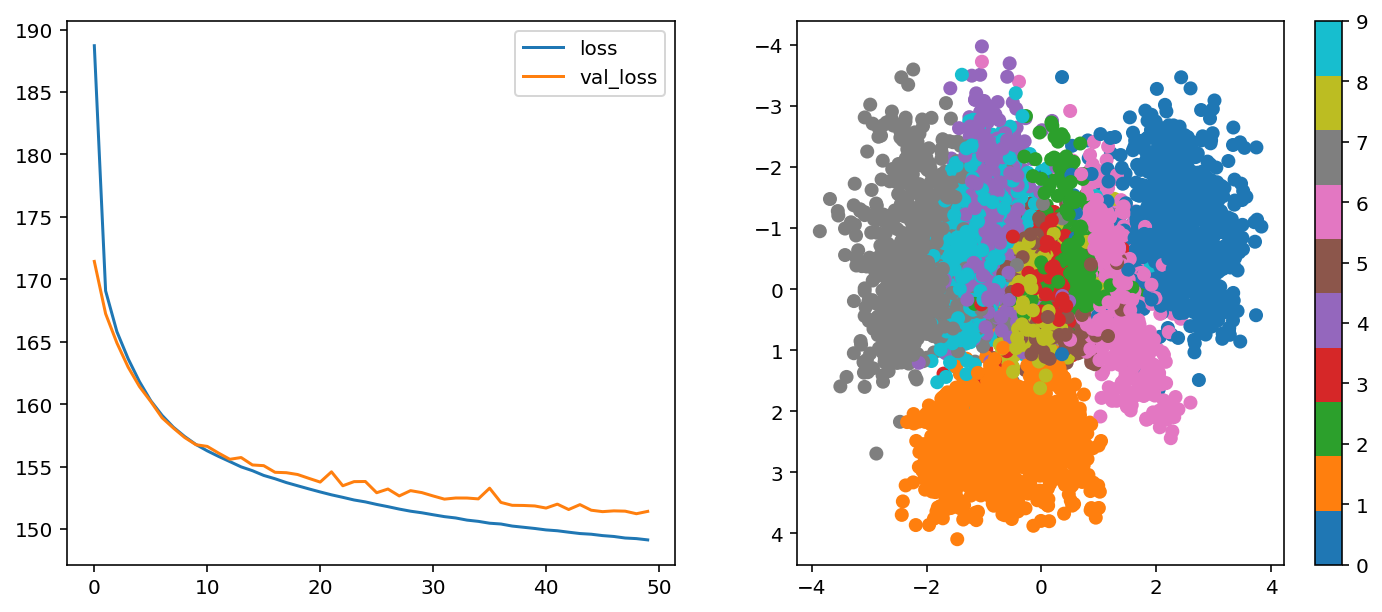

In [72]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.subplot(1, 2, 2)
# 'tab10' colour map has 10 discrete elements, which is useful for this case.
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')

# Reverse the y-axis, so there is better correspondence with the image below
plt.ylim(plt.ylim()[::-1])
plt.colorbar();

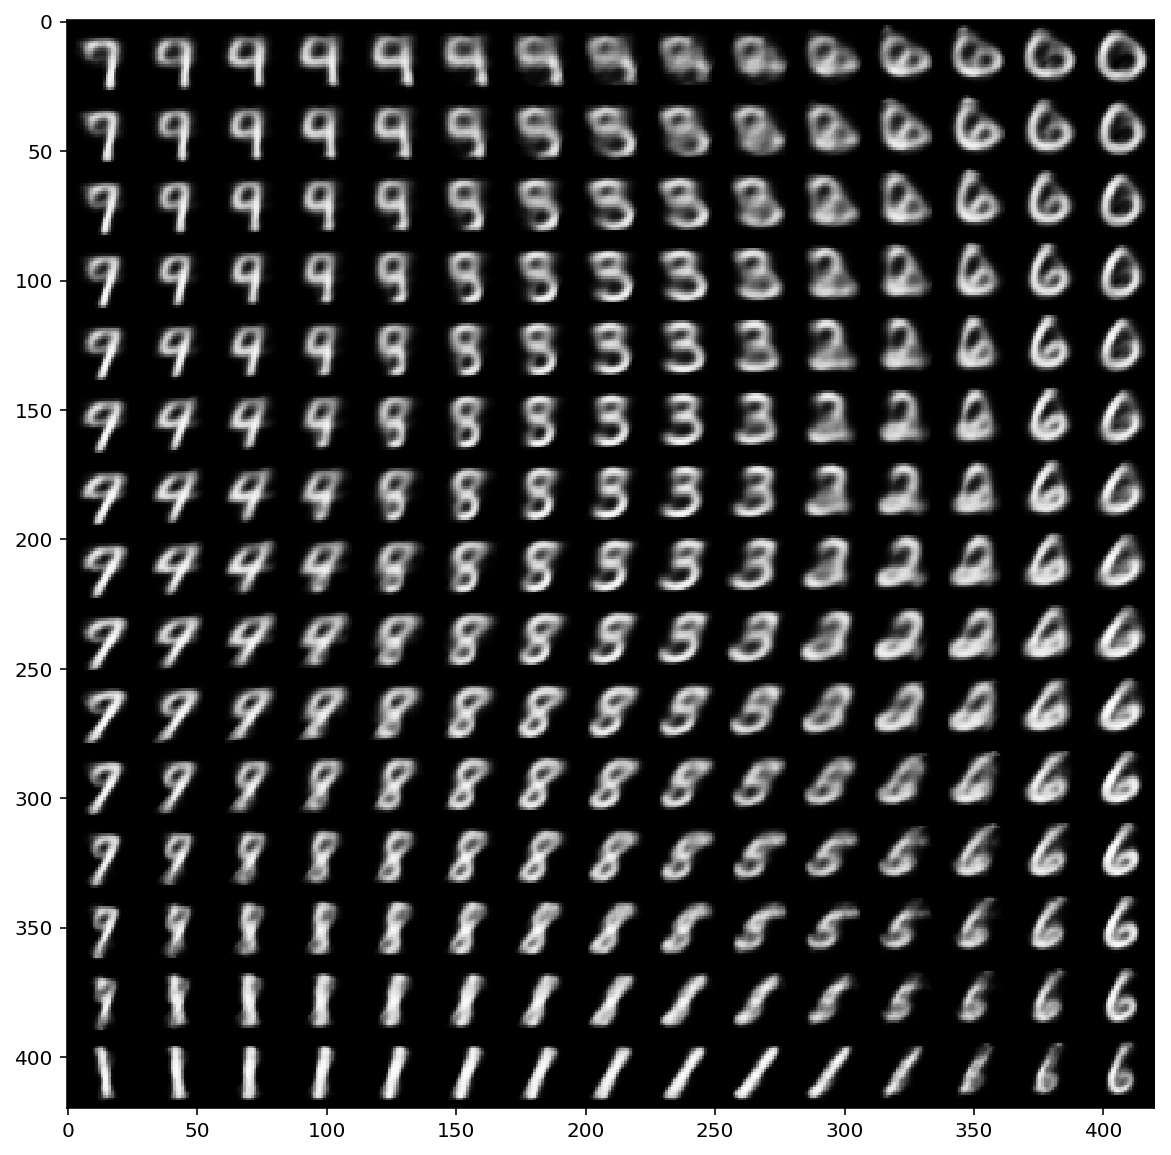

In [73]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r');

# Application to manifold example